In [1]:
import numpy as np
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from time import time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
np.random.seed(2000)

In [2]:
# common function used in both codes
def sparse_coding(dict_mat, signals, max_rep_error):
    """
    Sparse coding of a group of signals based on a given dictionary and specified number of atoms to use.

    Parameters:
    - dict_mat : The dictionary matrix.
    - signals : The signals to be represented.
    - max_rep_error : The maximal allowed representation error for each signal.

    Returns:
    - coff_mat : Sparse coefficient matrix.
    """
    num_atoms, num_sigs = dict_mat.shape[1], signals.shape[1]
    num_feats, num_atoms_dict = signals.shape[0], dict_mat.shape[0]

    coff_mat = np.zeros((num_atoms, num_sigs))
    max_sq_error = (max_rep_error**2) * num_feats

    max_num_coeffs = num_feats // 2

    for sig_idx in range(num_sigs):
        cur_coff = 0
        cur_sig = deepcopy(signals[:, sig_idx])
        cur_residual = deepcopy(cur_sig)
        selected_indices = np.array([], dtype=int)

        cur_residual_norm_sq = np.sum(cur_residual**2)
        num_selected_coeffs = 0

        while cur_residual_norm_sq > max_sq_error and num_selected_coeffs < max_num_coeffs:
            num_selected_coeffs += 1
            # Project the residual onto the dictionary
            projections = np.dot(dict_mat.T, cur_residual)

            selected_index = np.argmax(np.abs(projections))
            selected_indices = np.append(selected_indices, int(selected_index))

            # Update coefficients using pseudo-inverse
            cur_coff = np.dot(np.linalg.pinv(dict_mat[:, selected_indices[0:num_selected_coeffs]]), cur_sig)
            cur_residual = cur_sig - np.dot(dict_mat[:, selected_indices[0:num_selected_coeffs]], cur_coff)
            cur_residual_norm_sq = np.sum(cur_residual**2)

        # Update the coefficients matrix for the current signal
        if len(selected_indices) > 0:
            coff_mat[selected_indices, sig_idx] = deepcopy(cur_coff)

    return coff_mat

In [3]:

#code done by Sharan Rajamanoharan
class Simco():
    def __init__(self,blMat,dict_0,k=256, sigma=25, itr=15):
        self.Y = blMat # the vectorized form of the Image
        self.k = k # represents the number of atoms
        self.sigma = sigma # the parameter used to generate the noise in the Image
        self.dict_0 = deepcopy(dict_0) # the value intialized for the dictionary
        self.itr = itr # represents the number of iterations for the algorithm
        self.epsilon = 1.15*25 # represents the error tolerance level
        self.params ={} #other required parameters for SimCO algorithm
        # self.params.a

    def Simco_exec(self,verbose=False):
        """
        This is the main excecution function for both Matching pursuit and SimCO

        :param verbose: if True ,it prints the Sparsity level at each iteration

        :return:
        D: The Optimal value of the dictionary
        x: The sparse representation of the signal
        """
        D = deepcopy(self.dict_0)
        x = None
        for i in range(self.itr):
            x = sparse_coding(D,self.Y, self.epsilon)
            D,x,_ = self.SimDictUpdate(x,D)
            if verbose:
              print(f"iteration [{i+1}/{self.itr}] : sparsity [{np.count_nonzero(x)}/{x.shape[0]*x.shape[1]}]\n")

        return D

    def SimDictUpdate(self, sparse, Dict):
        """
        This function uses SimCO algorithm to update the Dictionary

        :parameter:
        sparse - the sparse representation vector obtained from Orthogonal pursuit matching

        Dict - The Inital value of dictionary

        :return:
        D - Matrix, the optimal dictionary value found using SimCO Algorithm
        """

        class dictParams():
            pass
        x = deepcopy(sparse)
        D = deepcopy(Dict)
        I = range(self.k)
        d = x.shape[0]
        m = self.Y.shape[0]
        Y = deepcopy(self.Y)
        I = np.intersect1d(range(d), I)
        Ic = np.setdiff1d(range(d), I)
        Yp = Y - np.dot(D[:, Ic], x[Ic, :])
        w = deepcopy(x != 0) #omega
        col = np.sum(w[I, :], axis=0) != 0

        dictParams.flag = np.zeros((self.itr,))
        dictParams.f_0 = np.zeros((self.itr,))
        dictParams.f_1 = np.zeros((self.itr,))
        dictParams.f_0_r = np.zeros((self.itr,))
        dictParams.f_1_r = np.zeros((self.itr,))
        dictParams.g = np.zeros((self.itr,))
        dictParams.topt = np.zeros((self.itr,))


        Y_i = deepcopy(Yp[:, col])
        D_i =  deepcopy(D[:,I])
        X_i = deepcopy(x[:, col][I, :])
        w_i = deepcopy(w[:,col][I,:])
        f_Y_i = np.linalg.norm(Yp[:, ~col], 'fro') ** 2
        for i in range(self.itr):
            if i == 0:
                dictParams.f_0_r[i] = np.linalg.norm(Y - np.dot(D, x), 'fro') ** 2
            else:
                dictParams.f_0_r[i] = dictParams.f_1_r[i - 1]

            D_i, X_i, params = self.SimcoOrthoGradientSearch(Y_i, D_i, w_i)
            D[:, I] = deepcopy(D_i)
            x[np.ix_(I, col)] = deepcopy(X_i)
            dictParams.flag[i] = params.flag
            dictParams.f_0[i] = params.f0 + f_Y_i
            dictParams.f_1[i] = params.f1 + f_Y_i
            dictParams.f_1_r[i] = np.linalg.norm(Y - np.dot(D, x), 'fro') ** 2
            dictParams.g[i] = deepcopy(params.gn)
            dictParams.topt[i] = deepcopy(params.topt)

            if params.flag != 0:
                dictParams.flag = dictParams.flag[0:i]
                dictParams.f_0 = dictParams.f_0[0:i]
                dictParams.f_1 = dictParams.f_1[0:i]
                dictParams.f_0_r = dictParams.f_0_r[0:i]
                dictParams.f_1_r =dictParams.f_1_r[0:i]
                dictParams.g = dictParams.g[0:i]
                dictParams.topt =dictParams.topt[0:i]
                break

            dictParams.t_4 = deepcopy(params.topt)

        D[:, I] = deepcopy(D_i)
        x[np.ix_(I, col)] = deepcopy(X_i)

        return D,x,dictParams

    def findGradDirection(self, Y_i,D_i,w_i):
        """
        This function computes the Gradient Descent direction for SimCO
        :param Y_i: the noisy Image
        :param D_i: the current dictionary
        :param w_i: The current sparse solution
        :return: The optimal direction and few parameters
        """
        w = deepcopy(w_i)
        D = deepcopy(D_i)
        Y = deepcopy(Y_i)
        m, n = Y_i.shape
        d = D_i.shape[1]
        x = np.zeros((d,n))
        w_l = np.sum(w_i,axis=0)
        mu=0 #regularizer
        sqrt = np.sqrt(mu)
        for i in range(n):
            L = deepcopy(w_l[i])
            x[w[:, i], i] = np.linalg.lstsq(np.append(D[:, w[:, i]], np.diag(sqrt * np.ones((L,))), axis=0),np.append(Y[:, i], np.zeros((L,)), axis=0))[0]
        Y_r = Y - np.dot(D,x)

        f = np.sum(Y_r * Y_r) + mu*np.sum(x*x)
        f_r =  np.sum(Y_r*Y_r)

        g = -2*np.dot(Y_r,x.T)
        G_corr = np.sum(D*g, axis=0)
        g = g -D*np.tile(G_corr, (m, 1))

        return f, x, g ,f_r

    def SimcoOrthoGradientSearch(self,Y_i,D_i,w_i):
        """
        This function uses Orthogonal Gradient search to find the optimal value of dictionary
        :param Y_i: The input signal
        :param D_i: The value of dictionary which needs to be optimized
        :param w_i: the value of omega_i
        :return: D: The optimised dictionary,
                 X: The sparse representation x
                 params: few parameters helpful in optimising the given problem
        """

        class params():
            pass

        D = deepcopy(D_i)
        Y = deepcopy(Y_i)
        c = (np.sqrt(5) - 1) / 2.0
        f_v = np.zeros((100,))
        t_v = np.zeros((100,))
        f_4_v = np.zeros((4,))
        t_4_v = np.zeros((4,))
        m,n = Y_i.shape
        d = D.shape[1]
        Gmin = 1e-5  # the gradients min value
        Lmin = 1e-6
        refine_max = 3  # the n.o of refinement iterations
        t_4_v[3] = 1e-2   # the t4's starting value

        f, x, g ,f_r = self.findGradDirection(Y_i,D,w_i)
        eval = 0
        f_v[eval] = deepcopy(f)
        t_v[eval] = 0
        w = deepcopy(w_i)
        params.gn = np.linalg.norm(g, 'fro') / np.linalg.norm(Y, 'fro') ** 2
        gColn = np.sqrt(np.sum(g * g, axis=0))
        g0 = gColn < Gmin * np.linalg.norm(Y, 'fro') ** 2 / n

        if np.sum(g0) == D.shape[1]:
            params.flag = 1
            params.fv = f_v[0:eval]
            params.tv = t_v[0:eval]
            params.topt = 0
            params.f0 = deepcopy(f)
            params.f1 = deepcopy(f)
            return D, x, params

        gColn[g0] = 0
        H = np.zeros((m, d))
        H[0, g0] = 1
        H[1:m, g0] = 0
        H[:, ~g0] = g[:, ~g0] * np.tile(-1 / gColn[~g0], (m, 1))
        step = gColn / np.mean(gColn)

        # Part A : find a good t4
        # set t4v and f4v;
        t_4_v[2] = t_4_v[3] * c
        t_4_v[1] = t_4_v[3] * (1 - c)
        f_4_v[0] = f_v[0]
        for eval in range(1, 4):
            t = t_4_v[eval]
            Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
            f_4_v[eval], _, _, _ = self.findGradDirection(Y, Dt, w)

        f_v[1:4] = f_4_v[1:4]
        t_v[1:4] = t_4_v[1:4]
        # loop to find a good t4
        while t_4_v[3] - t_4_v[0] >= Lmin:
            # if f(D(t1)) is not greater than f(D(t2)), then t4=t2, t3=c*t4,
            #   t2=(1-c)*t4
            if f_4_v[0] <= f_4_v[1]:
                t_4_v[3] = t_4_v[1]
                t_4_v[2] = t_4_v[3] * c
                t_4_v[1] = t_4_v[3] * (1 - c)
                f_4_v[3] = f_4_v[1]
                eval = eval + 1
                t = t_4_v[1]
                t_v[eval] = t
                Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
                f_t, _, _, _ = self.findGradDirection(Y, Dt, w)
                f_4_v[1] = f_t
                f_v[eval] = f_t
                eval = eval + 1
                t = t_4_v[2]
                t_v[eval] = t
                Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
                f_t, _, _, _ =self.findGradDirection(Y, Dt, w)
                f_4_v[2] = f_t
                f_v[eval] = f_t

            elif f_4_v[1] <= f_4_v[2]:
                t_4_v[3] = t_4_v[2]
                t_4_v[2] = t_4_v[1]
                t_4_v[1] = t_4_v[3] * (1 - c)
                f_4_v[3] = f_4_v[2]
                f_4_v[2] = f_4_v[1]
                eval = eval + 1
                t = t_4_v[1];
                t_v[eval] = t
                Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
                f_t, _, _, _ = self.findGradDirection(Y, Dt,w)
                f_4_v[1] = f_t
                f_v[eval] = f_t
                # if f(D(t3)) is greater than f(D(t4)), then t2=t3, t3=t4
                #   t4=t3/c
            elif f_4_v[2] > f_4_v[3]:
                t_4_v[1] = t_4_v[2]
                t_4_v[2] = t_4_v[3]
                t_4_v[3] = t_4_v[2] / c
                f_4_v[1] = f_4_v[2]
                f_4_v[2] = f_4_v[3]
                eval = eval + 1
                t = t_4_v[3]
                t_v[eval] = t
                Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
                f_t, _, _, _ = self.findGradDirection(Y, Dt,w);
                f_4_v[3] = f_t;
                f_v[eval] = f_t;
            else:
                break


        # refining the result
        eval_n = eval
        while (t_4_v[3] - t_4_v[0]) >= Lmin and eval - eval_n <= refine_max:
            # if f(D(t1))>f(D(t2))>f(D(t3)), then t1=t2, t2=t3, t3=t1+c*(t4-t1)
            if f_4_v[0] > f_4_v[1] and f_4_v[1] > f_4_v[2]:
                t_4_v[0] = t_4_v[1]
                t_4_v[1] = t_4_v[2]
                t_4_v[2] = t_4_v[0] + c * (t_4_v[3] - t_4_v[0]);
                f_4_v[0] = f_4_v[1];
                f_4_v[1] = f_4_v[2]
                eval = eval + 1
                t = t_4_v[2];
                t_v[eval] = t;
                Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
                f_t, _, _, _ = self.findGradDirection(Y, Dt, w);
                f_4_v[2] = f_t;
                f_v[eval] = f_t;
            # otherwise, t4=43, t3=t2, t2=t1+(1-c)(t4-t1)
            else:
                t_4_v[3] = t_4_v[2]
                t_4_v[2] = t_4_v[1]
                t_4_v[1] = t_4_v[0] + (1 - c) * (t_4_v[3] - t_4_v[0])
                f_4_v[3] = f_4_v[2];
                f_4_v[2] = f_4_v[1];
                eval = eval + 1;
                t = t_4_v[1];
                t_v[eval] = t;
                Dt = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
                f_t, _, _, _ = self.findGradDirection(Y, Dt, w)
                f_4_v[1] = f_t;
                f_v[eval] = f_t;

        # finalize
        f_v = f_v[0:eval]
        t_v = t_v[0:eval]
        findex = np.argmin(f_v)
        t = t_v[findex]
        D = D * np.tile(np.cos(step * t), (m, 1)) + H * np.tile(np.sin(step * t), (m, 1))
        # compute X
        f, X, _, _ = self.findGradDirection(Y, D, w)

        params.f0 = f_v[0]
        params.f1 = deepcopy(f)
        params.fv = deepcopy(f_v)
        params.tv = deepcopy(t_v)
        params.topt = deepcopy(t)
        params.flag = 0

        return D, X, params


In [4]:
# Generating initial dictionary using DCT
def generate_initial_dictionary(num_atoms, block_size):

    num_rows = int(np.ceil(np.sqrt(num_atoms)))
    dictionary = np.zeros((block_size, num_rows))

    for i in range(num_rows):
        basis_vector = np.cos(np.arange(block_size) * i * np.pi / num_rows)
        if i > 0:
            basis_vector = basis_vector - np.mean(basis_vector)

        dictionary[:, i] = basis_vector / np.linalg.norm(basis_vector)

    dictionary = np.kron(dictionary, dictionary)

    initial_dictionary = dictionary[:, :num_atoms]

    return initial_dictionary



def image_to_columns(image_array, block_size):

    image_height, image_width = image_array.shape
    block_height, block_width = block_size

    # Calculate the number of rows and columns in the result array
    block_rows = block_height
    num_cols = image_height - block_height + 1
    num_rows = image_width - block_width + 1

    # Create indices for rows and columns
    col_indices = np.reshape(range(block_rows), (-1, 1))
    row_indices = np.reshape(range(1, num_cols + 1), (1, -1))
    subs = col_indices + row_indices

    subs_flat = np.zeros((block_rows * block_width, num_cols))
    rows = np.array(range(block_rows))

    for i in range(block_width):
        subs_flat[i * block_rows + rows, :] = subs + image_height * i

    # Create the final indices for the result array
    result_indices = np.zeros((block_rows * block_width, num_cols * num_rows), dtype=int)
    cols = np.array(range(num_cols))

    for j in range(num_rows):
        result_indices[:, j * num_cols + cols] = subs_flat + image_height * j

    result_array = np.zeros((result_indices.shape[0], result_indices.shape[1]))
    # Fill the result array using the indices
    for i in range(result_indices.shape[0]):
        result_array[i, :] = deepcopy(
            image_array[np.unravel_index(result_indices[i, :] - 1, image_array.shape, order='F')]
        )

    return result_array

In [5]:
def denoise_image(image, num_atoms=256, noise_level=25):
    # Parameters
    noise_sigma = noise_level
    num_atoms_val = num_atoms
    image_height, image_width = image.shape
    c = 1.15
    block_size = 8
    max_num_blocks_to_train_on = 1000
    num_iters = 15
    error_goal = noise_sigma * c

    # Train a dictionary on blocks from the noisy image
    if np.prod(np.array([image_height, image_width]) - block_size + 1) > max_num_blocks_to_train_on:
        rand_permutation = np.random.permutation(np.prod(np.array([image_height, image_width]) - block_size + 1))
        selected_blocks = rand_permutation[:max_num_blocks_to_train_on]
        block_matrix = np.zeros((block_size ** 2, max_num_blocks_to_train_on))
        for i in range(max_num_blocks_to_train_on):
            row, col = np.unravel_index(selected_blocks[i], tuple(np.array(image.shape) - block_size + 1), order='F')
            curr_block = image[row:row + block_size, col:col + block_size]
            block_matrix[:, i] = np.reshape(curr_block, (-1,), order='F')
    else:
        block_matrix = image_to_columns(image, (block_size, block_size))

    # Make initial dictionary from DCT
    initial_dictionary = generate_initial_dictionary(num_atoms_val, block_size)

    vec_of_means = np.mean(block_matrix, axis=0)
    block_matrix = block_matrix - np.dot(np.ones((block_matrix.shape[0], 1)), np.reshape(vec_of_means, (1, -1), order='F'))

    print('Executing SimCO Algorithm...')
    simco_algo = Simco(block_matrix, initial_dictionary)
    dictionary = simco_algo.Simco_exec(verbose=True)

    # Denoise the image using the resulting dictionary
    error_threshold = noise_sigma * c
    blocks = image_to_columns(image, (block_size, block_size))
    idx = range(blocks.shape[1])

    for iters in range(0, blocks.shape[1], 30000):
        jump_size = min(iters + 30000, blocks.shape[1])
        vec_of_means = np.mean(blocks[:, iters:jump_size], axis=0)
        blocks[:, iters:jump_size] = blocks[:, iters:jump_size] - np.tile(vec_of_means, (blocks.shape[0], 1))
        coefs = sparse_coding(dictionary, blocks[:, iters:jump_size], error_threshold)
        blocks[:, iters:jump_size] = np.dot(dictionary, coefs) + \
                                  np.dot(np.ones((blocks.shape[0], 1)), np.reshape(vec_of_means, (1, -1), order='F'))

    count = 0
    weight = np.zeros((image_height, image_width))
    im_out = np.zeros((image_height, image_width))
    rows, cols = np.unravel_index(idx, tuple(np.array(image.shape) - block_size + 1), order='F')

    for i in range(len(cols)):
        col = cols[i]
        row = rows[i]
        block = np.reshape(blocks[:, count], (block_size, block_size), order='F')
        im_out[row:row+block_size, col:col+block_size] += block
        weight[row:row+block_size, col:col+block_size] += np.ones((block_size, block_size))
        count += 1

    # Final denoised image
    denoised_image = (image + 0.034 * noise_sigma * im_out) / (1.0 + 0.034 * noise_sigma * weight)
    return denoised_image


Executing SimCO Algorithm...


<ipython-input-3-9729540cc952>:126: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x[w[:, i], i] = np.linalg.lstsq(np.append(D[:, w[:, i]], np.diag(sqrt * np.ones((L,))), axis=0),np.append(Y[:, i], np.zeros((L,)), axis=0))[0]


iteration [1/15] : sparsity [616/256000]

iteration [2/15] : sparsity [475/256000]

iteration [3/15] : sparsity [426/256000]

iteration [4/15] : sparsity [402/256000]

iteration [5/15] : sparsity [383/256000]

iteration [6/15] : sparsity [377/256000]

iteration [7/15] : sparsity [371/256000]

iteration [8/15] : sparsity [367/256000]

iteration [9/15] : sparsity [365/256000]

iteration [10/15] : sparsity [359/256000]

iteration [11/15] : sparsity [358/256000]

iteration [12/15] : sparsity [357/256000]

iteration [13/15] : sparsity [356/256000]

iteration [14/15] : sparsity [356/256000]

iteration [15/15] : sparsity [356/256000]



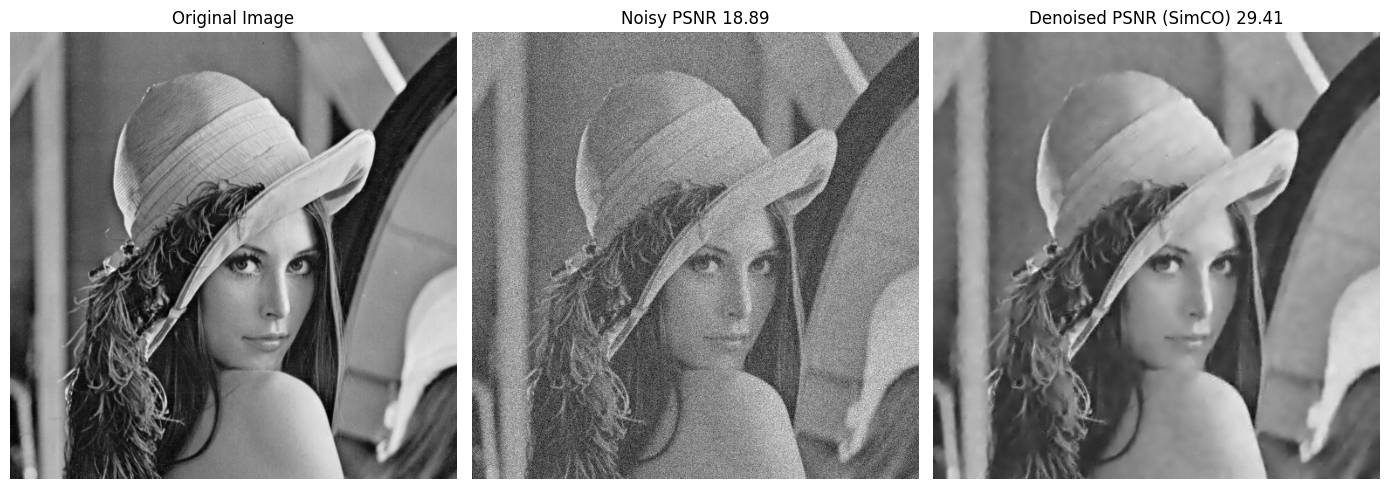

In [6]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

k = 256
sigma = 25

img = cv2.imread('lena512.bmp',0)
original_image = np.float64(img)

# Add Gaussian noise to the original image
noised_image = original_image + sigma * np.random.standard_normal(original_image.shape)

# Denoise the corrupted image using the learned dictionary
denoised_image = denoise_image(noised_image, num_atoms=k, noise_level=sigma)

# Calculate PSNR for the noisy and denoised images
noised_psnr = psnr(original_image, noised_image, data_range=original_image.max() - original_image.min())
denoised_psnr = psnr(original_image, denoised_image, data_range=original_image.max() - original_image.min())

# Display the results
plt.close('all')
plt.figure(figsize=(14, 10))

plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noised_image, cmap='gray')
plt.title(f'Noisy PSNR {noised_psnr:.2f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised PSNR (SimCO) {denoised_psnr:.2f}')
plt.axis('off')

plt.tight_layout()

plt.show()


In [7]:
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.util import img_as_ubyte


class Denoising():
    def __init__(self,img, original):
        self.original = original
        self.img = np.copy(img)
        self.h, self.w = img.shape
        # self.pad_img = None
        # self.s_wind = None
        # self. b_wind = None
        # self.nw = None
        self.working_img = np.copy(img)

    def Metrics(self, denoised_img,Type="Gaussian"):
        _psnr = psnr(self.original, denoised_img, data_range=self.original.max() - self.original.min())
        # psnr(original_image, denoised_image, data_range=original_image.max() - original_image.min())
        print("===========================================================")
        print(Type)
        print("===========================================================")
        print(f"PSNR | {_psnr}")
        print("===========================================================\n")

    # function for padding image
    def padImage(self, img, kernalSize):
        return np.pad(img, ((kernalSize // 2, kernalSize // 2), (kernalSize // 2, kernalSize // 2)), mode="constant")
    def getGaussianKernal(self, NW, sigma):
        # Calculate range of values
        range_vals = np.arange(-NW, NW + 1)

        # Create meshgrid
        x_coord, y_coord = np.meshgrid(range_vals, range_vals)

        # Calculating Gaussian kernel
        gaussian_kernel = np.exp(-(x_coord ** 2 + y_coord ** 2) / (2 * sigma ** 2))

        # Normalizing the kernel
        gaussian_kernel /= np.sum(gaussian_kernel)

        return gaussian_kernel


    def Gaussian(self, kernalSize=3, sigma=25):
        working_img = np.copy(self.img)
        pad_img = self.padImage(working_img, kernalSize)
        temp = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-kernalSize//2)**2 + (y-kernalSize//2)**2)/(2*sigma**2)),
        (kernalSize, kernalSize))
        kernal = temp / np.sum(temp)

        result = np.zeros_like(self.img)

        for i in range(self.h):
            for j in range(self.w):
                result[i, j] = np.sum(pad_img[i:i + kernalSize, j:j + kernalSize] * kernal)

        self.Metrics(result)
        return np.clip(result, 0, 255).astype(np.uint8)

    def Median(self, neighbourSize=3):
        working_img = np.copy(self.img)
        pad_img = self.padImage(working_img, neighbourSize)
        result = np.zeros_like(working_img)

        for i in range(self.h):
            for j in range(self.w):
                result[i, j] =  np.median(pad_img[i:i + neighbourSize, j:j + neighbourSize])

        self.Metrics(result, Type="Median")

        return result

    def Mean(self, neighbourSize=3):
        working_img = np.copy(self.img)
        pad_img = self.padImage(working_img, neighbourSize)
        result = np.zeros_like(working_img)
        for i in range(self.h):
            for j in range(self.w):
                result[i, j] = np.mean(pad_img[i:i + neighbourSize, j:j + neighbourSize])

        self.Metrics(result, Type="Mean")

        return result



In [8]:
def display(noisy_img,img):

    denoiser = Denoising(noisy_img, img)
    gauss = denoiser.Gaussian()
    median = denoiser.Median()
    mean = denoiser.Mean()
    return gauss, median, mean

gauss, median, mean = display(noised_image,original_image)

Gaussian
PSNR | 26.417324085722154

Median
PSNR | 25.590792495323726

Mean
PSNR | 26.416579168273174



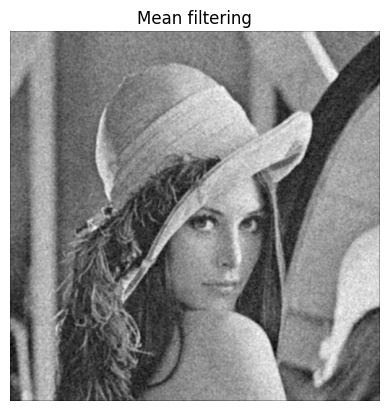

In [9]:
plt.imshow(mean,cmap="gray")
plt.title("Mean filtering")
plt.axis("off")
plt.show()

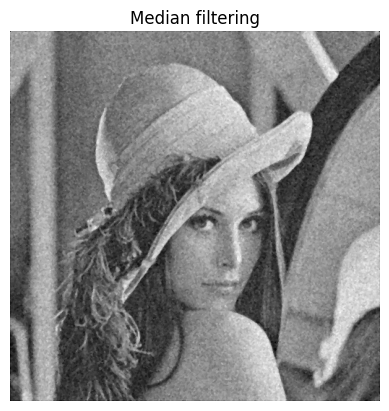

In [10]:
plt.imshow(median,cmap="gray")
plt.title("Median filtering")
plt.axis("off")
plt.show()

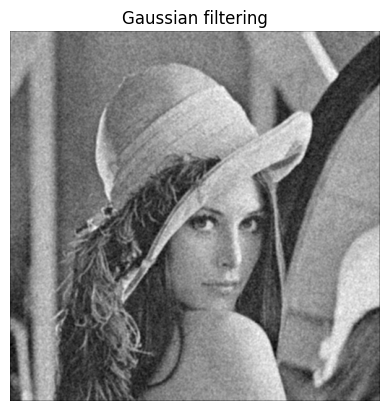

In [11]:
plt.imshow(gauss,cmap="gray")
plt.title("Gaussian filtering")
plt.axis("off")
plt.show()